<a href="https://colab.research.google.com/github/Abhishek-Garg-Ai/Sarcasm-Detection/blob/main/RedditSarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Reddit Sarcasm Detection/train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
df.nunique()

label                   2
comment            962294
author             256561
subreddit           14878
score                1291
ups                  1171
downs                   2
date                   96
created_utc       1004689
parent_comment     984286
dtype: int64

In [ ]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [ ]:
df.drop(['author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],inplace=True,axis=1)

In [ ]:
df.shape

(1010826, 2)

In [ ]:
df.drop_duplicates(inplace=True,ignore_index=True)
df.shape

(966209, 2)

In [ ]:
df.dropna(inplace=True)
df.isna().sum()

label      0
comment    0
dtype: int64

In [ ]:
df.label.value_counts()

1    486357
0    479850
Name: label, dtype: int64

##Text Cleaning

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
import string 
# from nltk.stem import Po
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)#unwanted words

In [ ]:
import re
def clean_text(text):
  final_text=[word.strip().lower() for word in text.split() if word.strip().lower() not in stop]
  final_text=[word for word in final_text if word.isalpha()]
  final_text=' '.join(final_text)
  final_text=re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]',' ',final_text)
  final_text=[word for word in final_text.split() if len(word)>1]
  return ' '.join(final_text).encode('ascii', 'ignore').decode('ascii')

In [ ]:
df['comment']=df['comment'].map(clean_text)

In [ ]:
df.head()

,label,comment
0,0,nc
1,0,know west teams play west teams east teams
2,0,underdogs earlier since announcement vegas lin...
3,0,meme funny none york ones
4,0,could use one


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df['comment'],df['label'],test_size=0.25,random_state=1,stratify=df['label'])

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((724655,), (241552,), (724655,), (241552,))

In [ ]:
y_test.value_counts()

1    121589
0    119963
Name: label, dtype: int64

###Max length

In [ ]:
word_count={}
for text in X_train:
  words=len(text.split())
  if words not in word_count.keys():
    word_count[words]=1
  else:
    word_count[words]+=1

# word_count

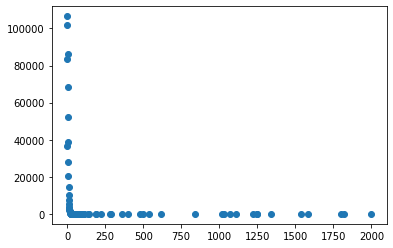

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(list(word_count.keys()),list(word_count.values()))

In [ ]:
count=0
new_word_count={}
for k,v in word_count.items():
  if(k<30):
    new_word_count[k]=word_count[k]
# new_word_count

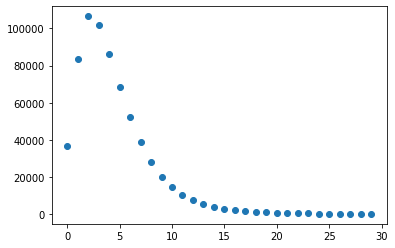

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(list(new_word_count.keys()),list(new_word_count.values()))

In [ ]:
count=0
new_word_count={}
for k,v in word_count.items():
  if(k<8):
    new_word_count[k]=word_count[k]
# new_word_count
sum(list(word_count.values())),sum(list(new_word_count.values()))

(676344, 573995)

##Tokenization

In [ ]:
import tensorflow as  tf
from tensorflow.keras.preprocessing.text import Tokenizer
top_k=50000
tokenizer=Tokenizer(oov_token='<UNK>',num_words=top_k)
tokenizer.fit_on_texts(X_train)

In [ ]:
len(tokenizer.word_index)

108822

In [ ]:
import pickle
# saving
with open('/content/drive/MyDrive/Reddit Sarcasm Detection/Temp/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
# loading
with open('/content/drive/MyDrive/Reddit Sarcasm Detection/Temp/tokenizer.pickle', 'rb') as handle:
    tokenizer=pickle.load(handle)

In [ ]:
tokenized_train=tokenizer.texts_to_sequences(X_train)
len(tokenizer.word_index),tokenized_train[:5]

(105032,
 [[7973, 1, 675, 2664, 1331, 277, 18, 266, 122, 1342],
  [1958, 684, 1816, 10373, 12147, 17294, 915, 538],
  [122, 1872, 728, 132, 1037],
  [2392],
  [870, 4004, 16628, 16666, 1245]])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_sequence=pad_sequences(tokenized_train,maxlen=8,padding='post')
train_sequence[:2]

array([[  675,  2664,  1331,   277,    18,   266,   122,  1342],
       [ 1958,   684,  1816, 10373, 12147, 17294,   915,   538]],
      dtype=int32)

In [ ]:
tokenized_test=tokenizer.texts_to_sequences(X_test)

In [ ]:
test_sequence=pad_sequences(tokenized_test,maxlen=8,padding='post')
# test_sequence[:2],X_test[0]#curfews is not available in train vocab

In [ ]:
y_test.shape

(241552,)

##Model

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Embedding,Bidirectional,LSTM,Flatten,Dropout,SpatialDropout1D,Input,TimeDistributed
from tensorflow.keras.layers import Flatten,Activation,RepeatVector,Permute,Multiply,Lambda

In [ ]:
embedded_dim=100#dimension of embedding layer
voc_size=top_k+1
max_sent_len=8

_input = Input(shape=[max_sent_len])

# get the embedding layer
embedded = Embedding(voc_size,embedded_dim,input_length=max_sent_len)(_input)
activations = LSTM(units, return_sequences=True)(embedded)

# compute importance for each step
attention = TimeDistributed(Dense(1, activation='tanh'))(activations) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

# apply the attention
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

probabilities = Dense(1, activation='sigmoid')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 8, 100)       5000100     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 8, 64)        42240       embedding_2[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 8, 1)         65          lstm_2[0][0]                     
____________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Reddit Sarcasm Detection/Temp/LSTM_Model2.h5', monitor='val_accuracy', verbose=1, save_best_only=True,
                                 mode='auto')

In [ ]:
model.fit(train_sequence,y_train,epochs=15,validation_data=(test_sequence,y_test),batch_size=2048,callbacks=[checkpoint])

Epoch 1/15
354/354 [==============================] - 22s 58ms/step - loss: 0.6380 - accuracy: 0.6276 - val_loss: 0.6242 - val_accuracy: 0.6456

Epoch 00001: val_accuracy improved from -inf to 0.64563, saving model to /content/drive/MyDrive/Reddit Sarcasm Detection/Temp/LSTM_Model2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
354/354 [==============================] - 19s 54ms/step - loss: 0.6100 - accuracy: 0.6614 - val_loss: 0.6233 - val_accuracy: 0.6474

Epoch 00002: val_accuracy improved from 0.64563 to 0.64737, saving model to /content/drive/MyDrive/Reddit Sarcasm Detection/Temp/LSTM_Model2.h5
Epoch 3/15
354/354 [==============================] - 19s 55ms/step - loss: 0.5956 - accuracy: 0.6731 - val_loss: 0.6287 - val_accuracy: 0.6447

Epoch 00003: val_accuracy did not improve from 0.64737
Epoch 4/15
354/354 [==============================] - 20s 56ms/step - loss: 0.5813 - accuracy: 0.6837 - val_loss: 0.6369 - val_accuracy: 0.6442

Epoch 00004: val_accuracy did not improve from 0.64737
Epoch 5/15
354/354 [==============================] - 19s 55ms/step - loss: 0.5638 - accuracy: 0.6947 - val_loss: 0.6486 - val_accuracy: 0.6426

Epoch 00005: val_accuracy did not improve from 0.64737
Epoch 6/15
354/354 [==============================] - 19s 53ms/step - loss: 0.5437 - accuracy: 0.7072 - val_los

In [ ]:
#1->0.647

In [ ]:
from keras.layers import Dense,Input,Embedding,LSTM,TimeDistributed,Flatten,Activation,RepeatVector,Permute,merge,Lambda
from keras.models import Model
from keras import backend as K
units = 64
max_length = 50
vocab_size = 5000#embeddings.shape[0]
embedding_size =100# embeddings.shape[1]


_input = Input(shape=[max_length], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        input_length=max_length,
        # trainable=trainable,
        # mask_zero=masking,
        # weights=[embeddings]
    )(_input)

activations = LSTM(units, return_sequences=True)(embedded)

# compute importance for each step
attention = TimeDistributed(Dense(1, activation='tanh'))(activations) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

# apply the attention
sent_representation = merge.Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 50, 100)      500000      input_10[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 50, 64)       42240       embedding_9[0][0]                
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 50, 1)        65          lstm_9[0][0]                     
______________________________________________________________________________________________

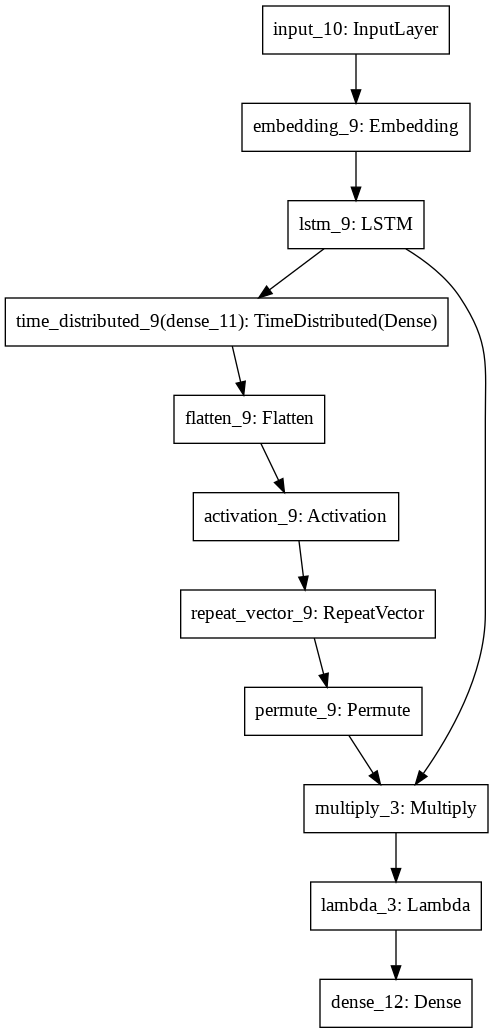

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,'model.png')